In [33]:
!pip install xgboost scikit-learn imblearn
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from google.colab import drive
from sklearn.decomposition import PCA

#--- I. Compréhension du Besoin ---

### Contexte et Objectifs :
L'objectif principal de cette analyse est de construire un modèle capable d'identifier les étudiants à risque d'abandon scolaire parmi les nouveaux étudiants.

Il s'agit d'un problème de classification binaire où l'étudiant est prédit comme
1 : 'Abandon',
soit comme
0 : 'Non-abandon'.
L'identification précoce des étudiants à risque permet de mettre en place des interventions proactives afin de les soutenir et de réduire le taux d'abandon.


###Métriques :
Étant donné la nature du problème, la mauvaise  d'un faux négatif (FN = prédire qu'un étudiant à risque ne va pas abandonner) est élevé car il mène à une absence d'intervention pour un étudiant qui en aurait besoin.
La prédiction d'un faux positif (prédire qu'un étudiant qui ne va pas abandonner est à risque) est importante, mais peut entraîner une surcharge des ressources d'intervention.
Par conséquent, les métriques clés sont :
- Recall : Mesure la capacité du modèle à identifier correctement tous les vrais positifs (étudiants qui vont réellement abandonner). Un Recall élevé est critique pour minimiser les faux négatifs.
- Précision : Mesure la proportion des positifs prédits qui sont réellement des positifs. Une bonne Précision est importante pour éviter de déclencher inutilement des interventions.
- F1-Score : Moyenne harmonique de la Précision et du Recall. Il offre un équilibre entre ces deux métriques, utile lorsque les classes sont déséquilibrées.
- Matrice de Confusion : Fournit une vue détaillée des vrais positifs, vrais négatifs, faux positifs et faux négatifs, permettant de comprendre où le modèle fait des erreurs.


###Mesures :

#--- II. Compréhension des Données, nettoyage, et prétraitement ---

###- Analyse des statistiques descriptives pour comprendre la distribution et la portée des variables numériques.

In [34]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset_Abandon_Scolaire.csv')
df.describe()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Taux_presence,Nombre_retards,Note_moyenne,Abandon
count,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.5930,84.637016,2.593500,13.441019,0.084000
std,2.0133,7.921973,1.788255,1.809283,0.277457
min,14.0000,59.586369,0.000000,7.615012,0.000000
25%,19.0000,79.279829,1.000000,12.268147,0.000000
50%,21.0000,84.813868,3.000000,13.470242,0.000000
75%,22.0000,90.169016,4.000000,14.688037,0.000000
max,28.0000,100.000000,9.000000,18.833574,1.000000


###- Identification et gestion des valeurs manquantes dans des colonnes

In [35]:
print(df.isna().sum())
print()
print()
df.info()

Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2000 non-null   int64  
 1   Sexe                 2000 non-null   object 
 2   Taux_presence        2000 non-null   float64
 3   Nombre_retards       2000 non-null   int64  
 4   Note_moyenne         2000 non-null   float64
 5   Situation_familiale  2000 non-null   object 
 6   Abandon              2000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 109.5+ KB



###- Analyse des distributions des variables via des histogrammes et des boxplots.

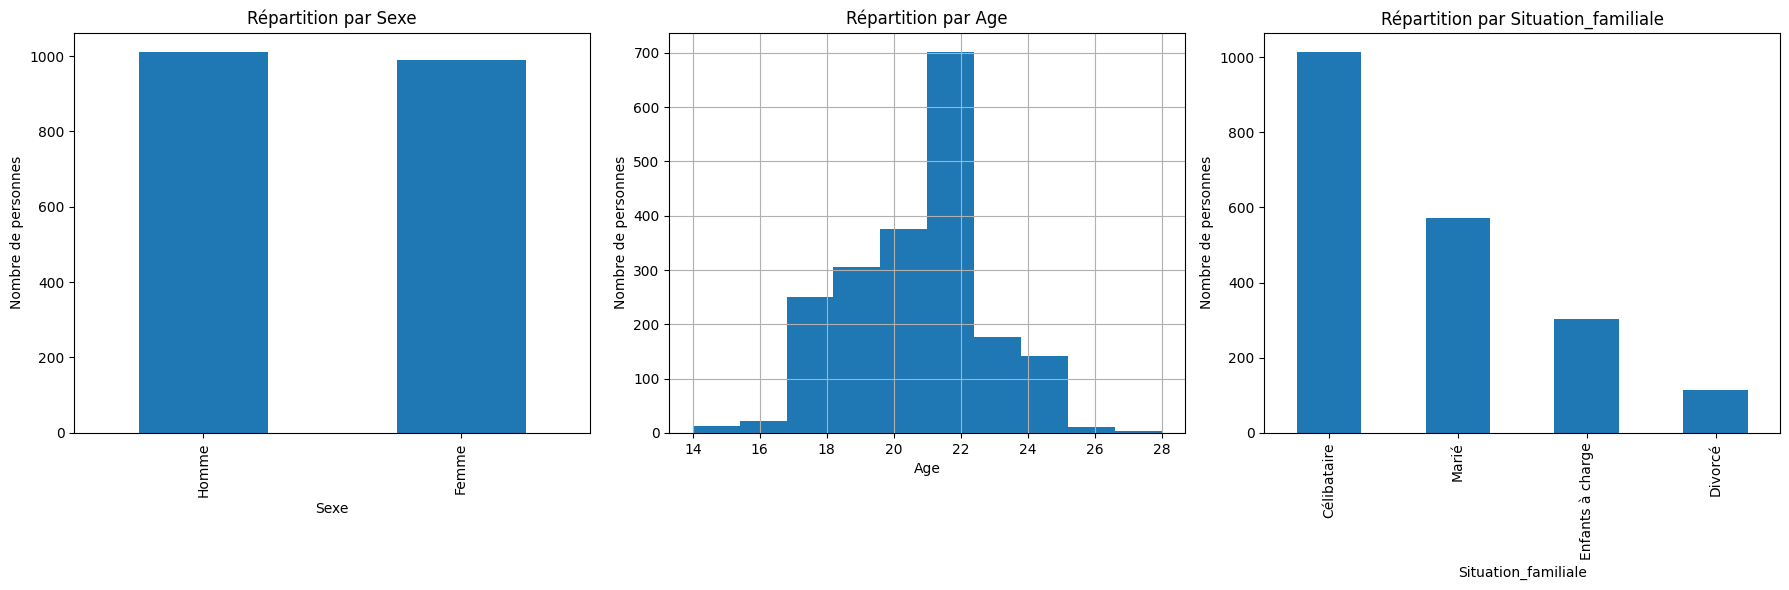

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
df['Sexe'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Répartition par Sexe')
axes[0].set_xlabel('Sexe')
axes[0].set_ylabel('Nombre de personnes')
df['Age'].hist(ax=axes[1])
axes[1].set_title('Répartition par Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Nombre de personnes')
df['Situation_familiale'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Répartition par Situation_familiale')
axes[2].set_xlabel('Situation_familiale')
axes[2].set_ylabel('Nombre de personnes')
plt.tight_layout()
plt.show()

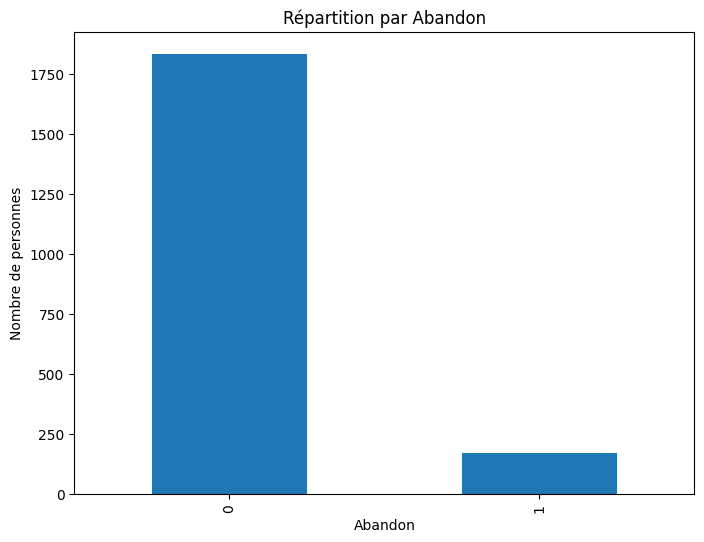

Abandon
0    1832
1     168
Name: count, dtype: int64


In [37]:
plt.figure(figsize=(8, 6))
df['Abandon'].value_counts().plot(kind='bar')
plt.title('Répartition par Abandon')
plt.xlabel('Abandon')
plt.ylabel('Nombre de personnes')
plt.show()
print(df['Abandon'].value_counts())


Distribution de 'Sexe' après encodage:
Sexe
0    1011
1     989
Name: count, dtype: int64

Distribution de 'Situation_familiale' après encodage:
Situation_familiale
0    1014
1     571
3     302
2     113
Name: count, dtype: int64


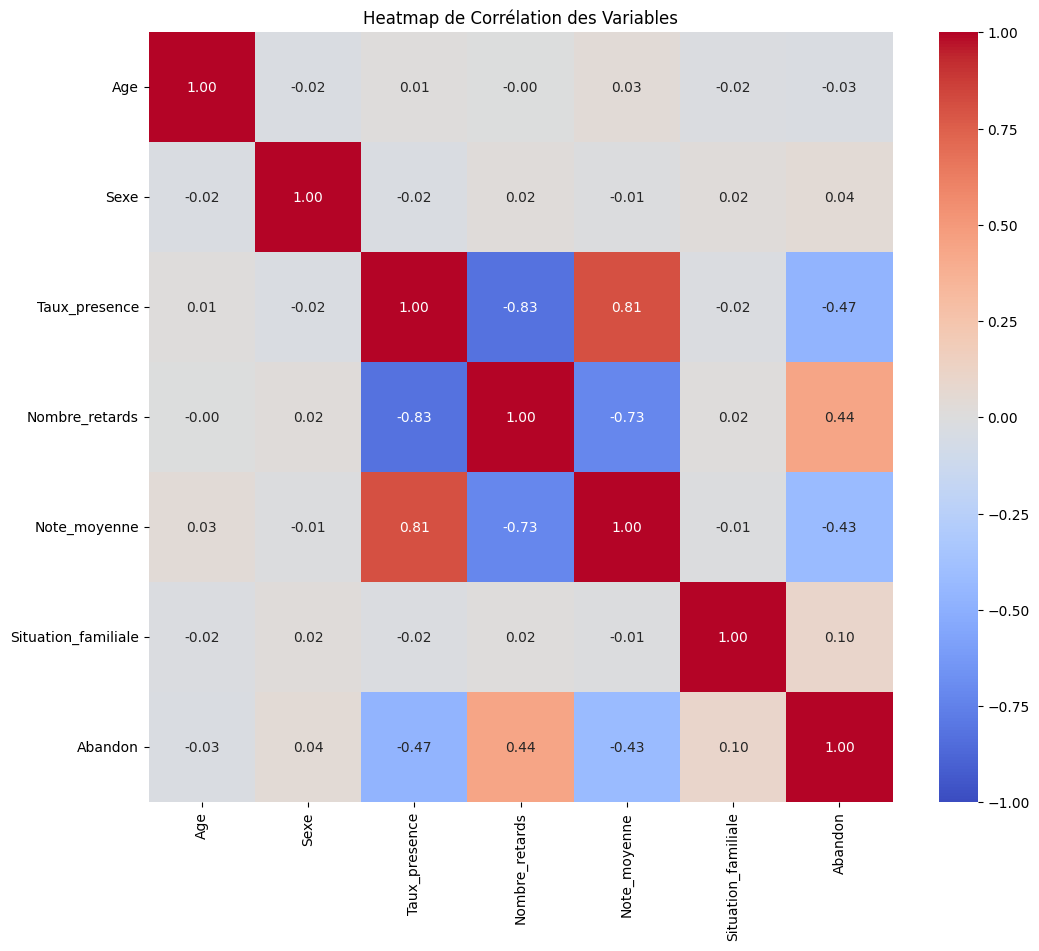

In [38]:
sexe_mapping = {'Femme': 1, 'Homme': 0}
df['Sexe'] = df['Sexe'].map(sexe_mapping).fillna(-1).astype(int)
print("\nDistribution de 'Sexe' après encodage:")
print(df['Sexe'].value_counts())

situation_mapping = {'Célibataire': 0, 'Marié': 1, 'Divorcé': 2, 'Enfants à charge': 3}
df['Situation_familiale'] = df['Situation_familiale'].map(situation_mapping).fillna(-1).astype(int)
print("\nDistribution de 'Situation_familiale' après encodage:")
print(df["Situation_familiale"].value_counts())


plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Heatmap de Corrélation des Variables')
plt.show()

Data after standardization:
X_train head:
           Age      Sexe  Taux_presence  Nombre_retards  Note_moyenne  \
836   1.722804  1.005731      -0.170638        0.224127      0.356682   
575  -2.251533  1.005731      -1.111067        0.224127     -0.769107   
557  -0.264364  1.005731       0.136322        0.776552      0.569605   
1235  1.722804  1.005731      -1.327649        0.776552     -0.233850   
1360 -0.264364  1.005731       0.576851       -0.880723      0.647539   

      Situation_familiale  
836             -0.792675  
575             -0.792675  
557             -0.792675  
1235            -0.792675  
1360             0.150986  

X_test head:
           Age      Sexe  Taux_presence  Nombre_retards  Note_moyenne  \
1860 -0.264364  1.005731      -0.248402       -0.328298     -0.308657   
353  -0.264364 -0.994302      -0.818298        0.776552     -1.117824   
1333  1.226012  1.005731       1.684274       -1.433149      1.552587   
905   0.232428 -0.994302       1.484692      

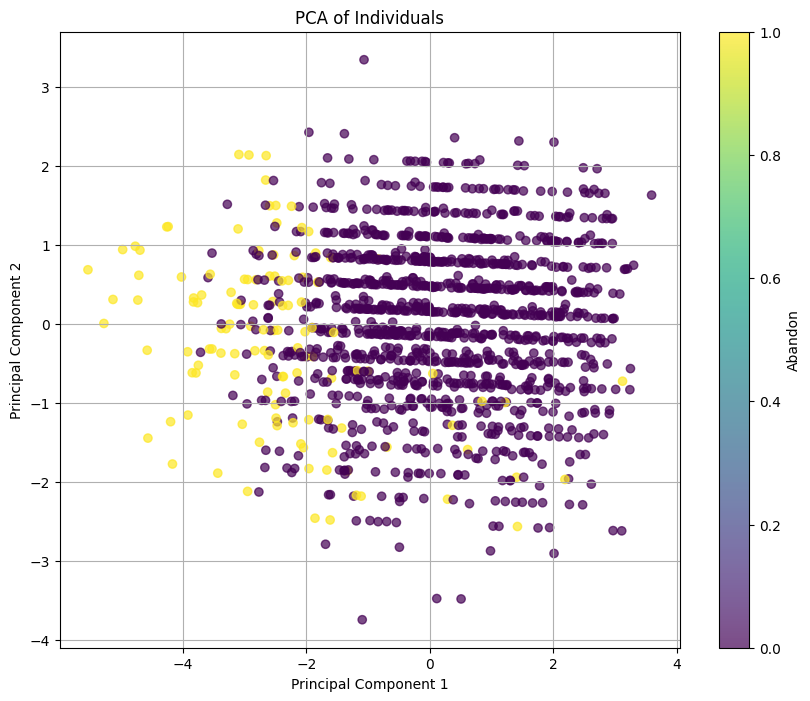

Explained variance ratio by component: [0.43209522 0.17097447 0.16497178 0.16372319 0.0436928  0.02454254]
Cumulative explained variance ratio: [0.43209522 0.60306969 0.76804147 0.93176466 0.97545746 1.        ]


In [39]:
X = df.drop('Abandon', axis=1)
y = df['Abandon']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
numerical_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Data after standardization:")
print("X_train head:")
print(X_train.head())
print("\nX_test head:")
print(X_test.head())

abandon_1_indices = y_test[y_test == 1].index
X_test_abandon_1 = X_test.loc[abandon_1_indices]
y_test_abandon_1 = y_test.loc[abandon_1_indices]

abandon_0_count_test = y_test[y_test == 0].shape[0]
abandon_1_count_test = y_test[y_test == 1].shape[0]

needed_abandon_1 = int(abandon_0_count_test * 0.50)
samples_to_generate = needed_abandon_1 - abandon_1_count_test

print(f"Original Abandon 0 count in test: {abandon_0_count_test}")
print(f"Original Abandon 1 count in test: {abandon_1_count_test}")
print(f"Needed Abandon 1 count in test (50% of Abandon 0): {needed_abandon_1}")
print(f"Number of Abandon 1 samples to generate: {samples_to_generate}")

if samples_to_generate > 0 and not X_test_abandon_1.empty:

    samples_to_augment_indices = np.random.choice(X_test_abandon_1.index, size=samples_to_generate, replace=True)
    X_to_augment = X_test.loc[samples_to_augment_indices]
    y_to_augment = y_test.loc[samples_to_augment_indices]

    numerical_cols_abandon_1 = X_to_augment.select_dtypes(include=np.number).columns

    noise_std_dev = 0.05

    X_augmented = X_to_augment.copy()
    for col in numerical_cols_abandon_1:
        noise = np.random.normal(loc=0, scale=noise_std_dev, size=X_augmented[col].shape)
        X_augmented[col] = X_augmented[col] + noise

    X_test_augmented = pd.concat([X_test, X_augmented], ignore_index=True)
    y_test_augmented = pd.concat([y_test, y_to_augment], ignore_index=True)

    print("\nTest data after augmentation:")
    print(y_test_augmented.value_counts())
    print("X_test_augmented shape:", X_test_augmented.shape)
    print("y_test_augmented shape:", y_test_augmented.shape)

elif samples_to_generate <= 0:
    print("\nNo augmentation needed as the desired ratio is met or exceeded.")
    X_test_augmented = X_test.copy()
    y_test_augmented = y_test.copy()
else:
    print("\nCannot augment data as there are no 'Abandon' == 1 samples in the test set.")
    X_test_augmented = X_test.copy()
    y_test_augmented = y_test.copy()

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Individuals')
plt.colorbar(label='Abandon')
plt.grid(True)
plt.show()


print("Explained variance ratio by component:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))


Analysis of abandoned profiles:

Distribution of 'Taux_presence' for abandoned students:
count    168.000000
mean      72.261378
std        6.624905
min       59.586369
25%       68.489415
50%       72.162242
75%       74.076252
max      100.000000
Name: Taux_presence, dtype: float64


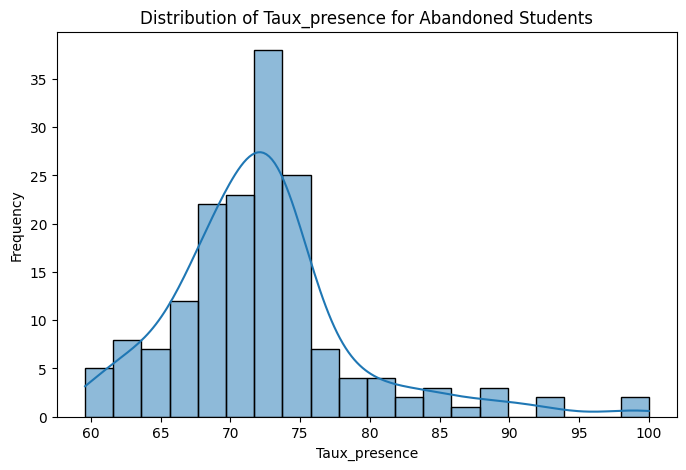


Distribution of 'Note_moyenne' for abandoned students:
count    168.000000
mean      10.892211
std        1.749632
min        7.615012
25%        9.652085
50%       10.744832
75%       11.875896
max       17.624967
Name: Note_moyenne, dtype: float64


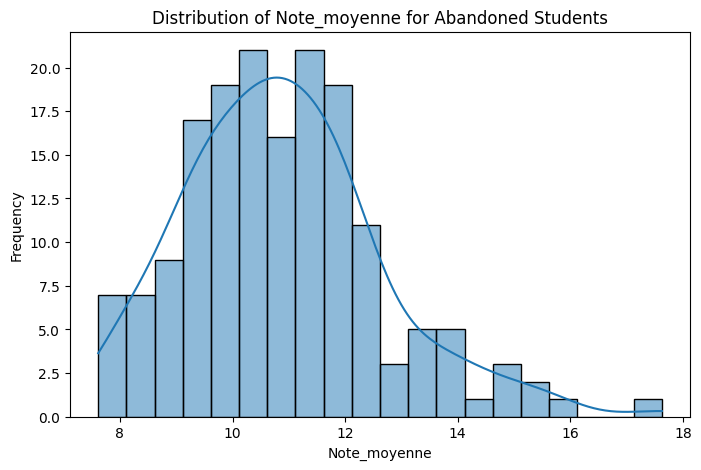


Comparison of 'Taux_presence' between abandoned and non-abandoned students:


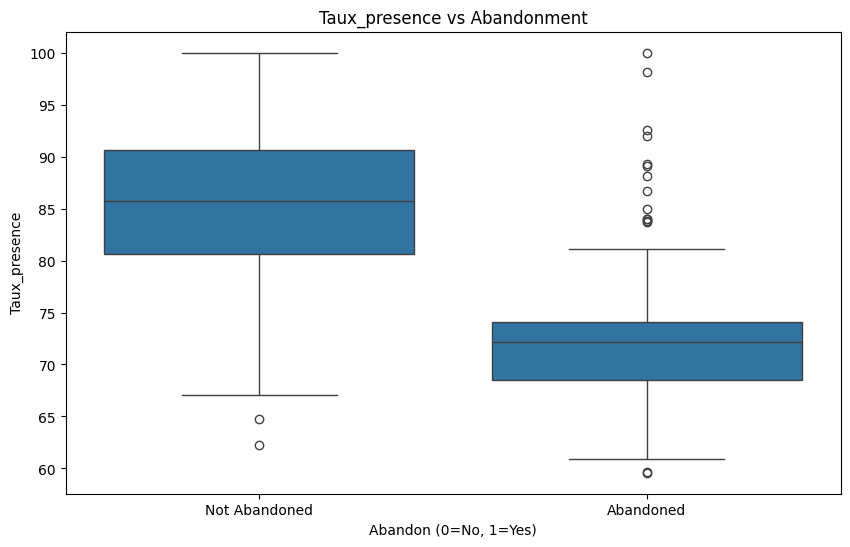


Comparison of 'Note_moyenne' between abandoned and non-abandoned students:


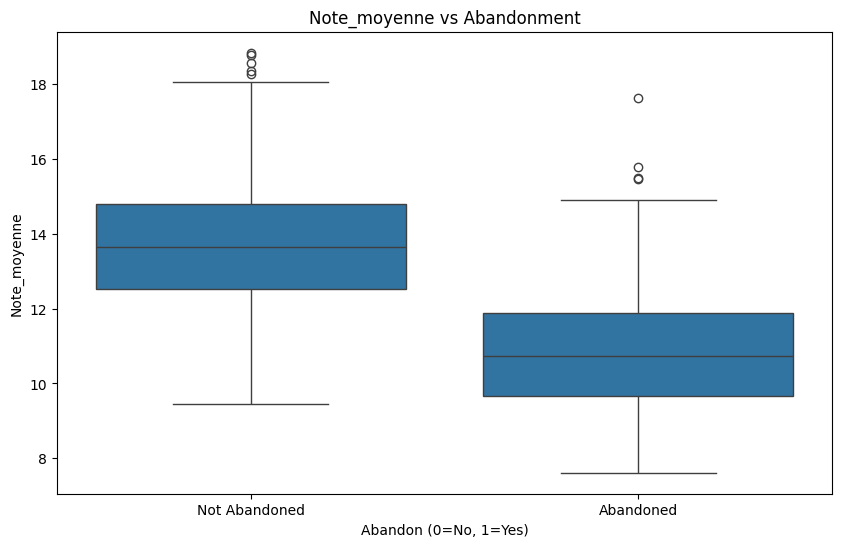

In [40]:
# Filter the dataframe to include only individuals who abandoned
abandoned_df = df[df['Abandon'] == 1].copy()

if 'Taux_presence' in df.columns and 'Note_moyenne' in df.columns:

    print("\nAnalysis of abandoned profiles:")

    print("\nDistribution of 'Taux_presence' for abandoned students:")
    print(abandoned_df['Taux_presence'].describe())
    if not abandoned_df['Taux_presence'].empty:
        plt.figure(figsize=(8, 5))
        sns.histplot(abandoned_df['Taux_presence'], kde=True, bins=20)
        plt.title('Distribution of Taux_presence for Abandoned Students')
        plt.xlabel('Taux_presence')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No data to plot for Taux_presence in abandoned profiles.")

    print("\nDistribution of 'Note_moyenne' for abandoned students:")
    print(abandoned_df['Note_moyenne'].describe())
    if not abandoned_df['Note_moyenne'].empty:
        plt.figure(figsize=(8, 5))
        sns.histplot(abandoned_df['Note_moyenne'], kde=True, bins=20)
        plt.title('Distribution of Note_moyenne for Abandoned Students')
        plt.xlabel('Note_moyenne')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No data to plot for Note_moyenne in abandoned profiles.")

    print("\nComparison of 'Taux_presence' between abandoned and non-abandoned students:")
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Abandon', y='Taux_presence', data=df)
    plt.title('Taux_presence vs Abandonment')
    plt.xlabel('Abandon (0=No, 1=Yes)')
    plt.ylabel('Taux_presence')
    plt.xticks([0, 1], ['Not Abandoned', 'Abandoned'])
    plt.show()

    print("\nComparison of 'Note_moyenne' between abandoned and non-abandoned students:")
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Abandon', y='Note_moyenne', data=df)
    plt.title('Note_moyenne vs Abandonment')
    plt.xlabel('Abandon (0=No, 1=Yes)')
    plt.ylabel('Note_moyenne')
    plt.xticks([0, 1], ['Not Abandoned', 'Abandoned'])
    plt.show()

else:
    print("The columns 'Taux_presence' or 'Note_moyenne' are not found in the dataframe.")
    print("Please check the column names in your dataset.")
    print("Available columns are:", df.columns.tolist())


In [41]:
pca_df = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

pca_components = pd.DataFrame(pca.components_, columns=X_train.columns, index=[f'PC{i+1}' for i in range(pca.components_.shape[0])])

print("\nPCA Components (Loadings):")
print(pca_components)

print("\nPCA Transformed Data (first 5 rows):")
print(pca_df.head())


PCA Components (Loadings):
          Age      Sexe  Taux_presence  Nombre_retards  Note_moyenne  \
PC1  0.003057 -0.040703       0.590264       -0.571685      0.568234   
PC2  0.631565 -0.473173      -0.023853        0.015111     -0.012917   
PC3  0.309211  0.878814       0.007313       -0.001283      0.043221   
PC4  0.710590  0.037447       0.000414        0.001373      0.017680   
PC5 -0.020443 -0.026345      -0.044214        0.681431      0.729781   
PC6  0.012165  0.006370       0.805613        0.456724     -0.377071   

     Situation_familiale  
PC1            -0.014457  
PC2            -0.613407  
PC3            -0.360766  
PC4             0.702385  
PC5             0.002412  
PC6            -0.004523  

PCA Transformed Data (first 5 rows):
        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.050382  1.101261  1.716410  0.711650  0.356942 -0.138647
1 -1.257345 -1.371819  0.431968 -2.132769 -0.341807 -0.520116
2 -0.070093 -0.155490  1.112695 -0.695763  0.915821  0

#--- III. Modélisation ---

###Sélection des Modèles :
Pour ce problème de classification binaire, plusieurs types de modèles sont pertinents. Le code fourni se concentre sur XGBoost.

XGBoost : Un algorithme de gradient boosting performant, capable de capturer des relations non linéaires complexes entre les variables. Il est souvent utilisé pour les tâches de classification grâce à sa robustesse, sa régularisation intégrée, et ses capacités d’optimisation.

D'autres modèles mentionnés dans le plan (Arbre de Décision, KNN) sont également valides pour ce type de problème.

In [42]:
# Data Augmentation avec SMOTE pour l'équilibrage des classes
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)

# Pipeline de preprocessing
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('xgb', XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42))
])

# Grille d'hyperparamètres pour le tuning
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2]
}

# Recherche d'hyperparamètres
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Évaluation
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.named_steps['xgb'].feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(feature_importance.head(10))

Meilleurs paramètres: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__subsample': 0.8}
Accuracy: 0.9433
AUC-ROC: 0.9727
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       554
           1       0.59      0.83      0.69        46

    accuracy                           0.94       600
   macro avg       0.79      0.89      0.83       600
weighted avg       0.96      0.94      0.95       600

Feature importance:
               feature  importance
2        Taux_presence    0.579061
5  Situation_familiale    0.181308
3       Nombre_retards    0.140851
4         Note_moyenne    0.054866
1                 Sexe    0.028558
0                  Age    0.015356


<ipython-input-43-cf70f0e4dd40>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')


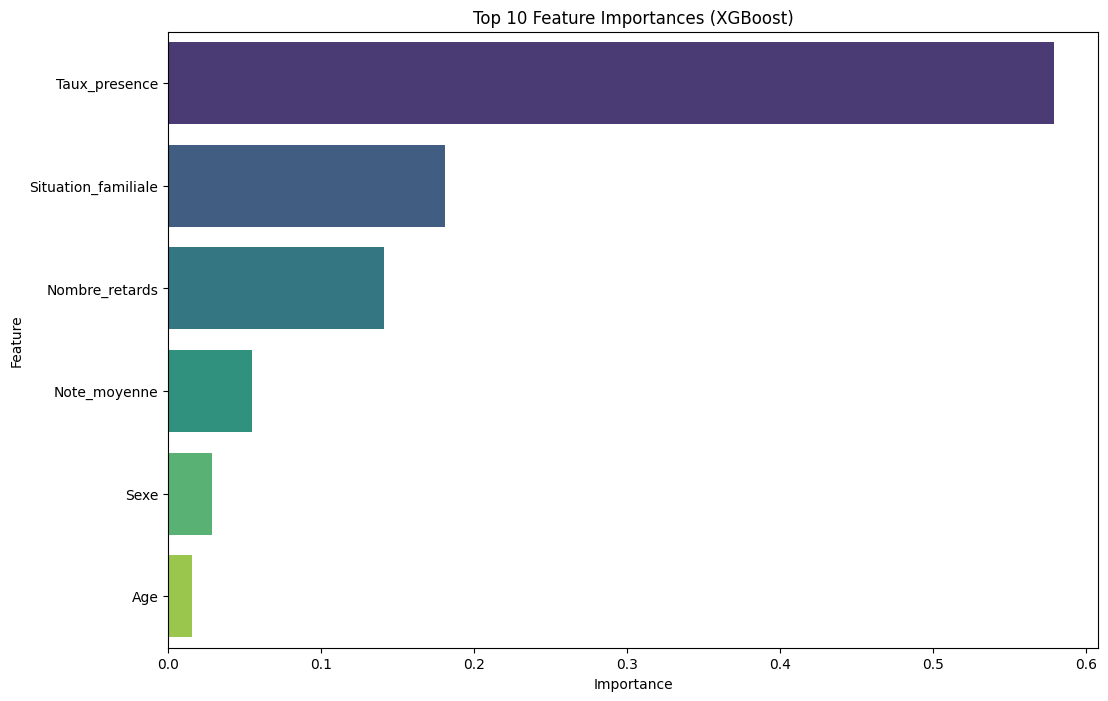

In [43]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#--- IV. Validation et Interprétation ---

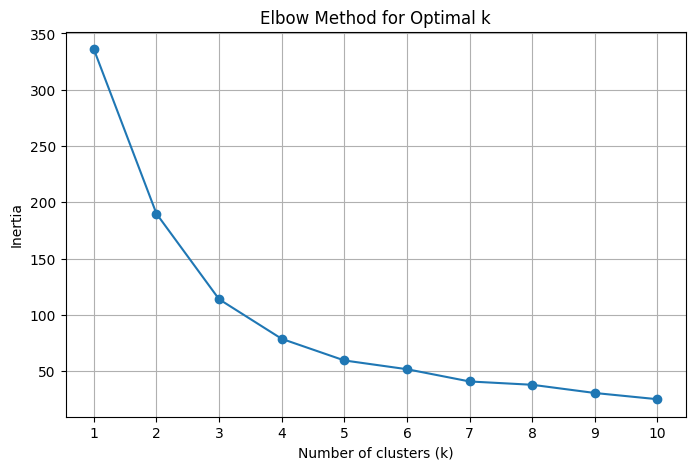


Analysis of 3 clusters for abandoned students:

--- Cluster 0 (n=53) ---
             Age  Situation_familiale
count  53.000000            53.000000
mean   20.415094             2.886792
std     1.691994             0.319878
min    17.000000             2.000000
25%    19.000000             3.000000
50%    20.000000             3.000000
75%    22.000000             3.000000
max    25.000000             3.000000

Situation_familiale distribution:
Situation_familiale
3    0.886792
2    0.113208
Name: proportion, dtype: float64

--- Cluster 1 (n=57) ---
             Age  Situation_familiale
count  57.000000            57.000000
mean   21.912281             0.508772
std     1.169260             0.570802
min    21.000000             0.000000
25%    21.000000             0.000000
50%    22.000000             0.000000
75%    22.000000             1.000000
max    25.000000             2.000000

Situation_familiale distribution:
Situation_familiale
0    0.526316
1    0.438596
2    0.035088
Nam

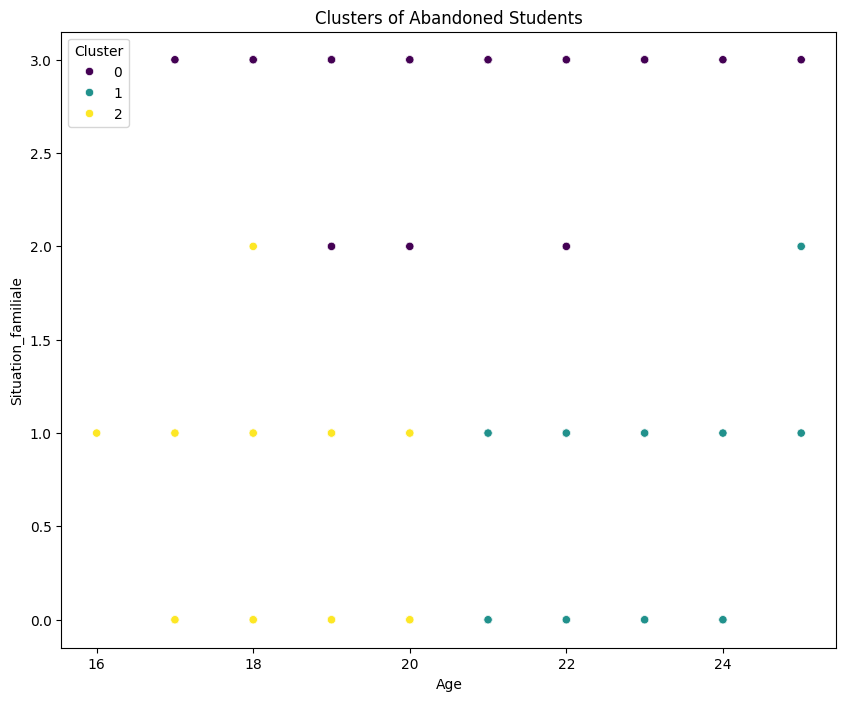

In [44]:

abandoned_df = df[df['Abandon'] == 1].copy()

if abandoned_df.empty:
    print("No abandoned students found in the dataset.")
else:

    features_for_clustering = ['Age', 'Situation_familiale']

    missing_features = [f for f in features_for_clustering if f not in abandoned_df.columns]
    if missing_features:
        print(f"The following features for clustering are missing from the dataset: {missing_features}")
        print("Clustering cannot be performed.")
    else:
        X_abandoned = abandoned_df[features_for_clustering]

        # Scale the features
        scaler_cluster = StandardScaler()
        X_scaled_abandoned = scaler_cluster.fit_transform(X_abandoned)

        inertia = []
        max_k = 10
        for k in range(1, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X_scaled_abandoned)
            inertia.append(kmeans.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_k + 1), inertia, marker='o')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Elbow Method for Optimal k')
        plt.xticks(range(1, max_k + 1))
        plt.grid(True)
        plt.show()

        n_clusters = 3

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        abandoned_df['Cluster'] = kmeans.fit_predict(X_scaled_abandoned)

        print(f"\nAnalysis of {n_clusters} clusters for abandoned students:")
        for cluster_id in range(n_clusters):
            cluster_data = abandoned_df[abandoned_df['Cluster'] == cluster_id]
            print(f"\n--- Cluster {cluster_id} (n={len(cluster_data)}) ---")
            print(cluster_data[features_for_clustering].describe())
            if 'Situation_familiale' in features_for_clustering:
                 print("\nSituation_familiale distribution:")
                 print(cluster_data['Situation_familiale'].value_counts(normalize=True))

        if len(features_for_clustering) >= 2:
            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=abandoned_df, x=features_for_clustering[0], y=features_for_clustering[1], hue='Cluster', palette='viridis')
            plt.title('Clusters of Abandoned Students')
            plt.xlabel(features_for_clustering[0])
            plt.ylabel(features_for_clustering[1])
            plt.show()
        elif len(features_for_clustering) == 1:
             print("\nCannot visualize clusters in 2D with only one clustering feature.")

        if len(features_for_clustering) > 2:
            from sklearn.decomposition import PCA
            pca_cluster = PCA(n_components=2)
            principal_components_abandoned = pca_cluster.fit_transform(X_scaled_abandoned)
            pca_abandoned_df = pd.DataFrame(data = principal_components_abandoned, columns = ['principal component 1', 'principal component 2'])
            pca_abandoned_df['Cluster'] = abandoned_df['Cluster'].reset_index(drop=True) # Add cluster labels

            plt.figure(figsize=(10, 8))
            sns.scatterplot(data=pca_abandoned_df, x='principal component 1', y='principal component 2', hue='Cluster', palette='viridis')
            plt.title('Clusters of Abandoned Students (PCA Reduced)')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.show()



###Évaluation des Performances :
Le modèle final optimisé (XGBoost + SMOTE) est évalué sur l'ensemble de test, qui n'a pas été vu pendant l'entraînement et l'optimisation.

Les métriques calculées sur l'ensemble de test sont : Accuracy, Precision (Abandon), Recall (Abandon), et F1 (Abandon).

La recall et le F1-score sont les métriques qui nous intéressent.
Nous estimons qu'il est prefferable de se concentrer sur la couverture des abandon que sur la certitude


Metrics on Test Set:
      Metric     Score
0  Precision  0.593750
1     Recall  0.826087
2   F1-Score  0.690909


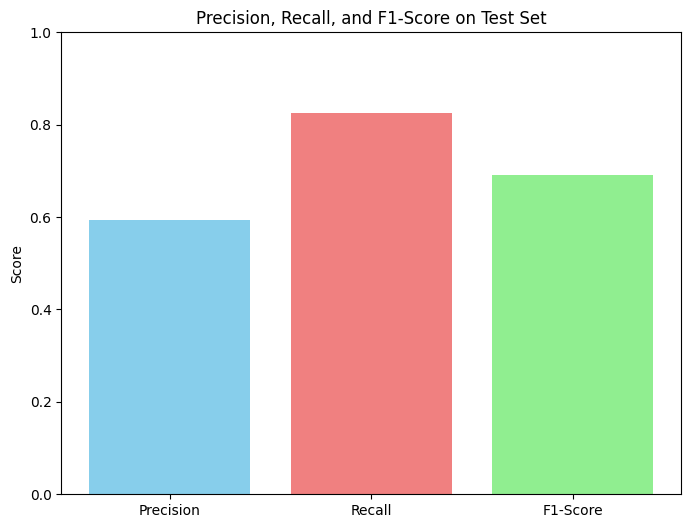

In [45]:
# Calculer precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Créer un DataFrame pour visualiser les métriques
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Score': [precision, recall, f1]
})

# Afficher les métriques
print("\nMetrics on Test Set:")
print(metrics_df)

# Afficher les courbes (représentation simple des valeurs ponctuelles)
plt.figure(figsize=(8, 6))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['skyblue', 'lightcoral', 'lightgreen'])
plt.ylim(0, 1) # Les scores sont entre 0 et 1
plt.title('Precision, Recall, and F1-Score on Test Set')
plt.ylabel('Score')
plt.show()




Matrice de confusion sur l'ensemble de Test:


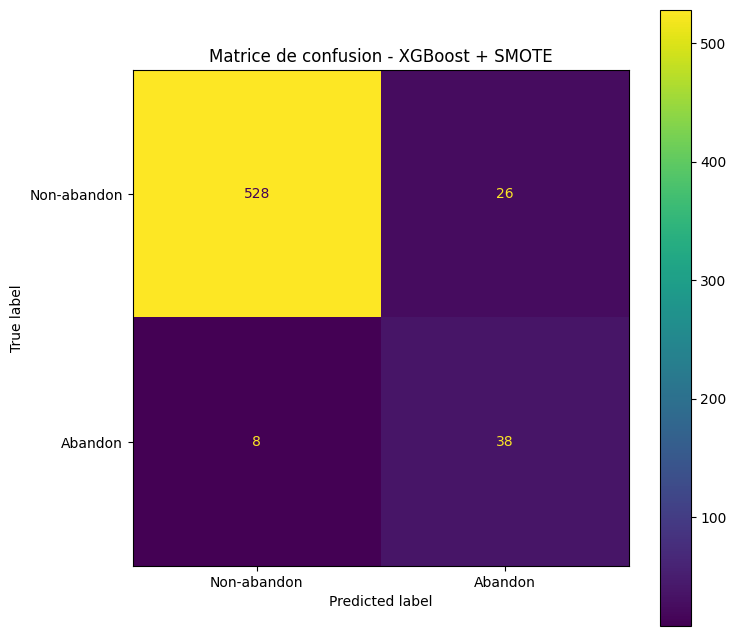

In [46]:
# Matrice de confusion
print("\nMatrice de confusion sur l'ensemble de Test:")
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['Non-abandon', 'Abandon'], ax=ax)
plt.title('Matrice de confusion - XGBoost + SMOTE')
plt.show()


- L'objectif est d'atteindre un Recall élevé (idéalement > 80%) tout en maintenant une Précision acceptable et un bon F1-score.
Le tableau de résultats récapitule les performances obtenues sur l'ensemble de test


#--- Conclusion et Perspectives ---

Le modèle XGboost, entraîné avec SMOTE et optimisé via GridSearchCV, semble capable d'identifier les étudiants à risque d'abandon, comme le montrent les métriques sur l'ensemble de test (en particulier le Recall).
L'analyse des coefficients du modèle confirme l'importance des indicateurs de performance académique (taux de présence, notes, retards) comme principaux facteurs de risque.
L'analyse des sous-clusters d'abandoneurs est précieuse pour comprendre les différentes 'raisons' ou profils d'abandon, permettant d'adapter les stratégies d'intervention (ex: tutorat, soutien psychologique, aide sociale).
Il est également necessaire de demander davantage de données d'eleve qui abandonne afin d'avoir une plus large vision des cas.